In [2]:
import load
import oed
import figure

In [5]:
# jsonファイルの読み込み
result = load.load_result_json("../result/Result.json")

gene = result[0]["gene"]

N, M, theta, w_on, w_off, w, g, w_osc, w_nmj = oed.weight(gene)
alpha, x_peak, y_peak, dt, T, f, v, time, tau = oed.constant("setting")
N_, M_, f_inv, T_ = oed.time_constant_step(gene, "setting")

In [ ]:
import cv2
import glob
import matplotlib.pyplot as plt

connectome_img = [
    cv2.imread(i)
    for i in sorted(glob.glob("../analysis/Result_aiz_negative_0/figure/connectome/*"))
]

for i in connectome_img:
    plt.imshow(cv2.cvtColor(i, cv2.COLOR_BGR2RGB))
    plt.show()

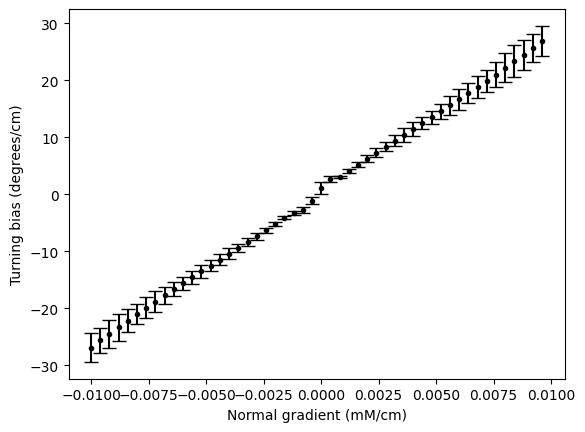

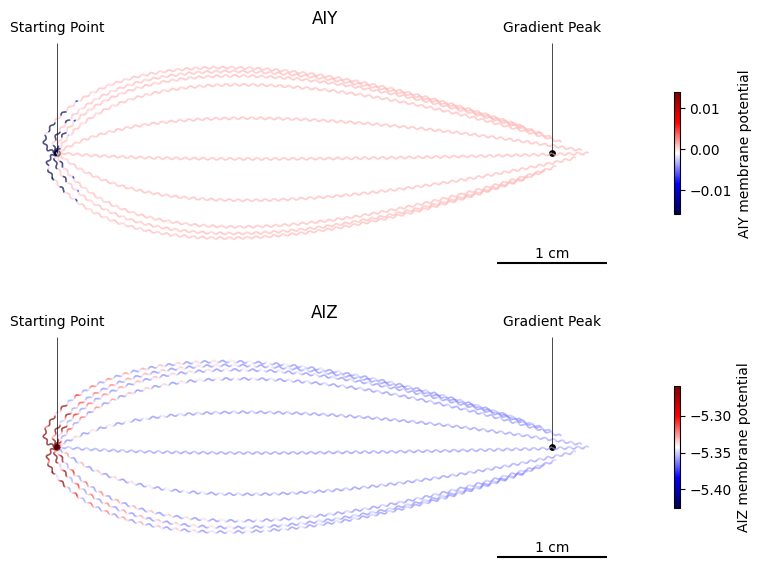

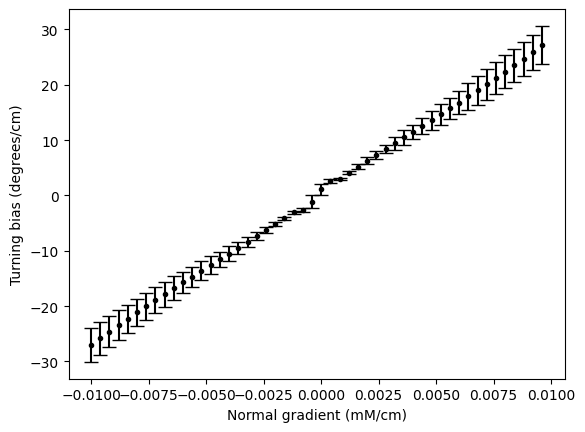

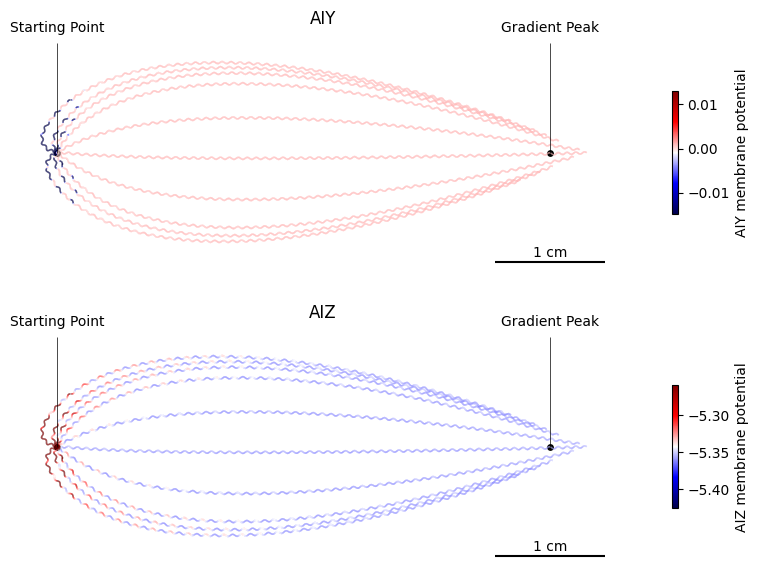

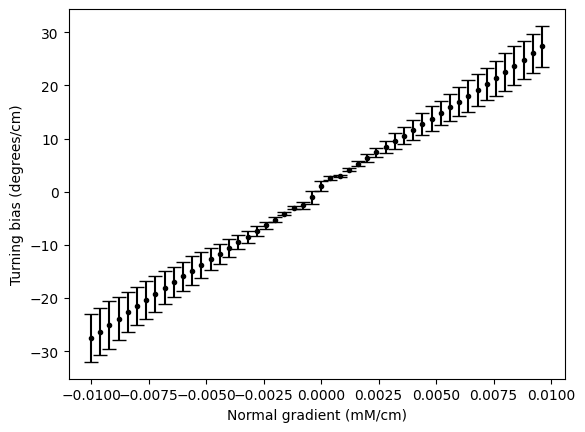

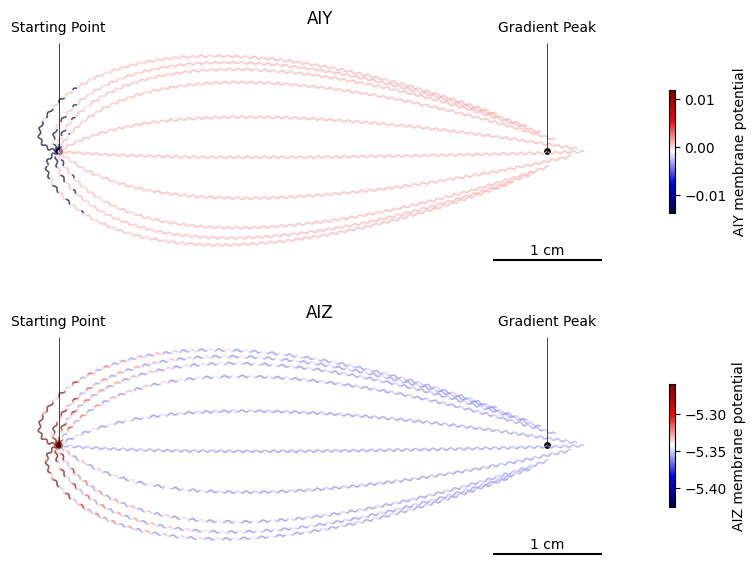

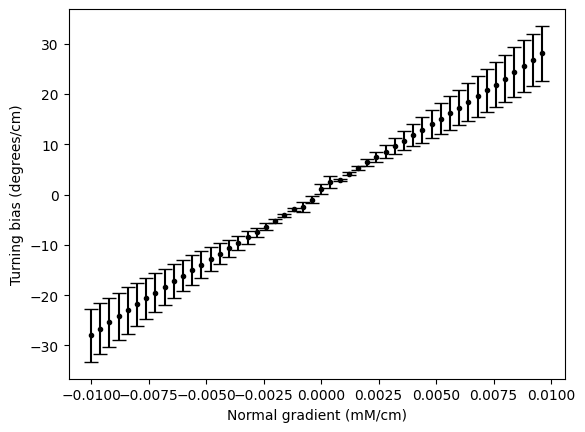

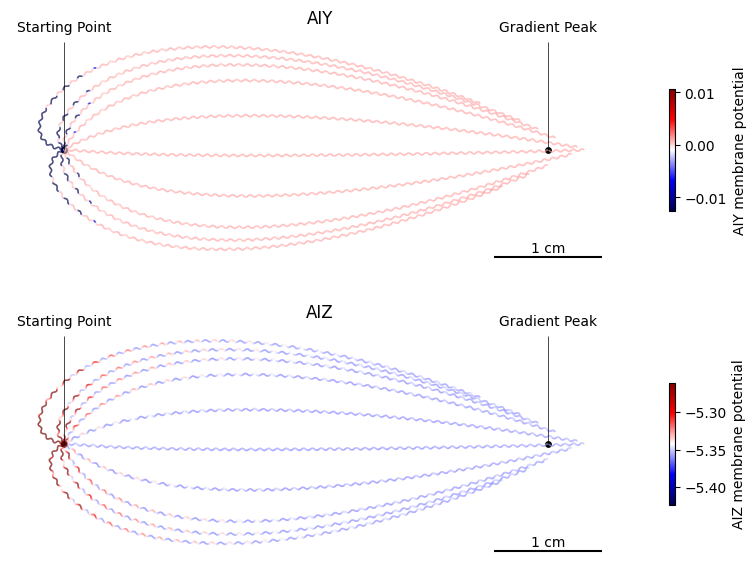

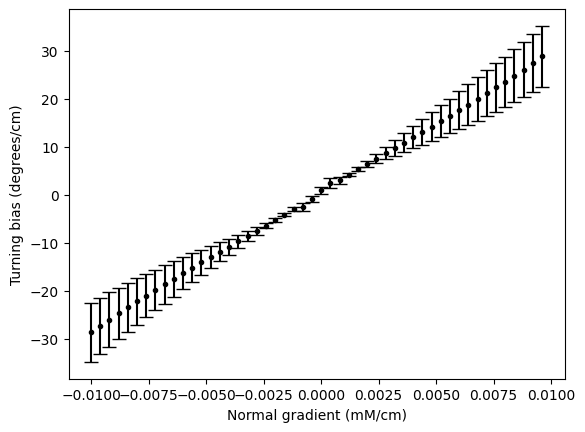

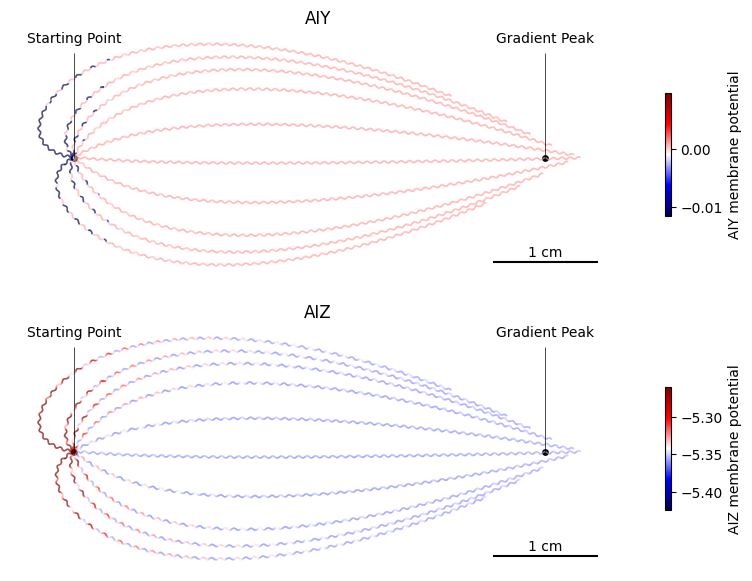

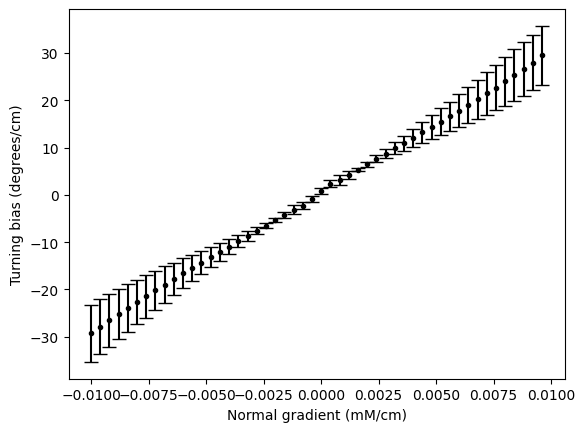

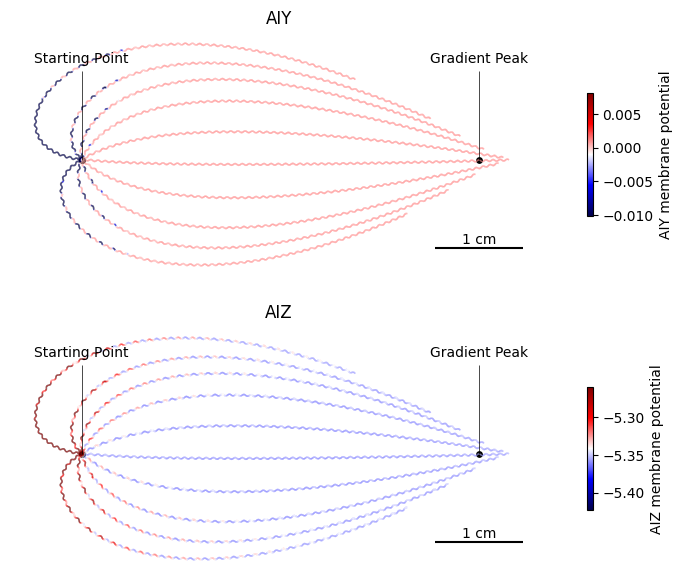

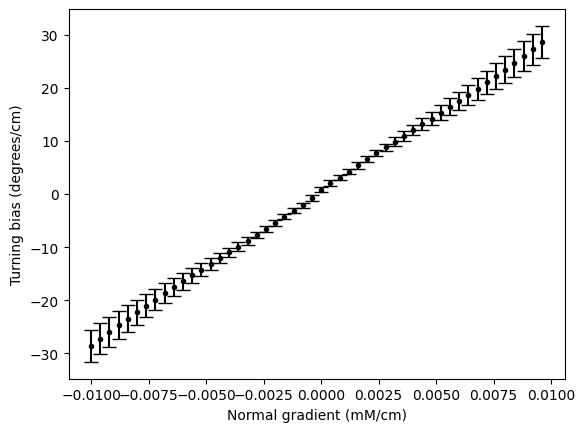

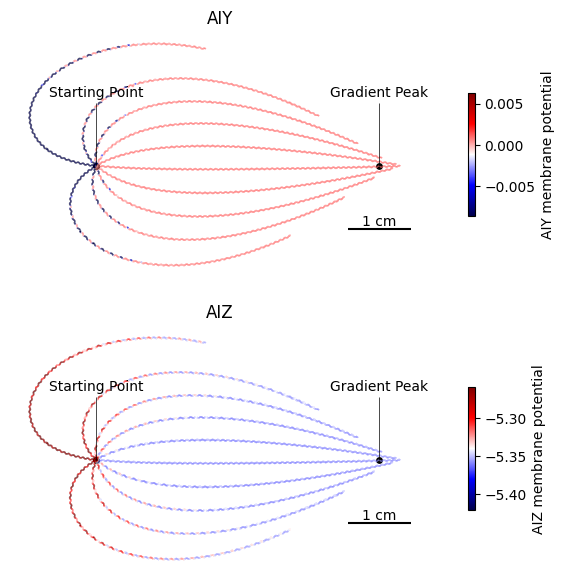

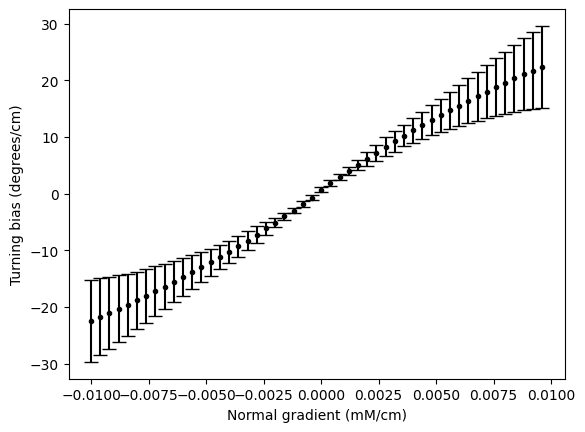

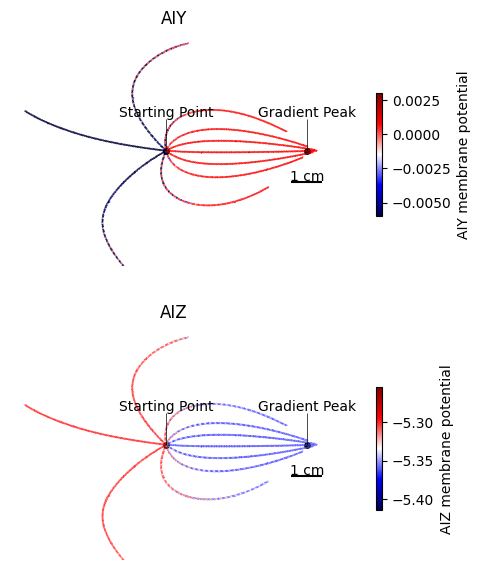

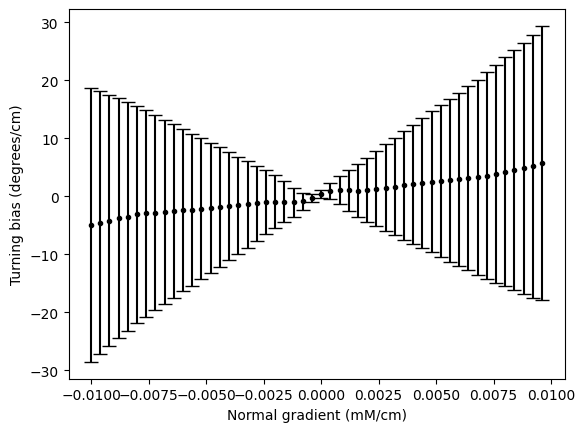

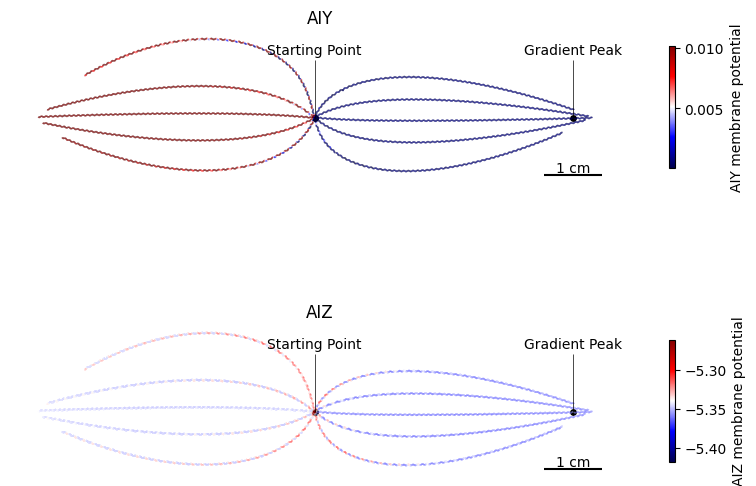

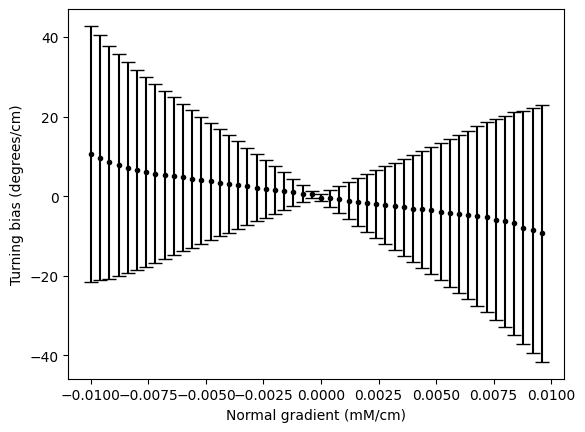

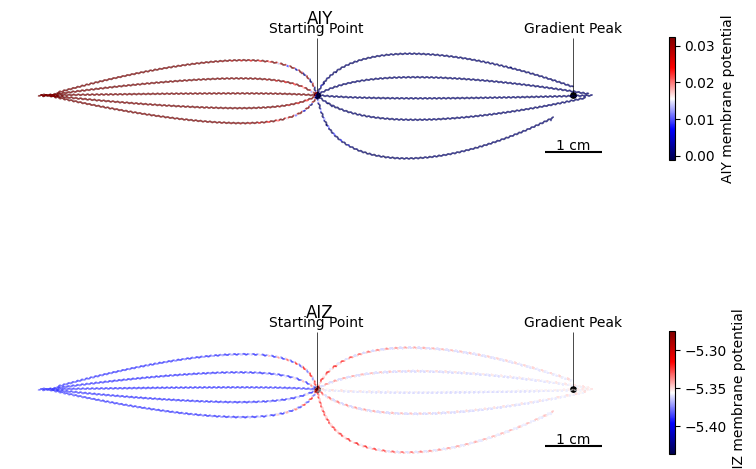

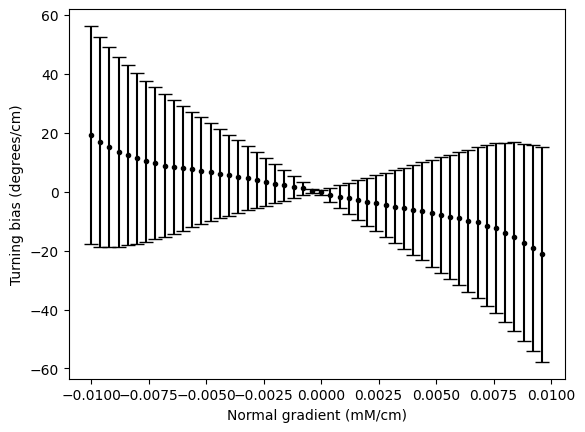

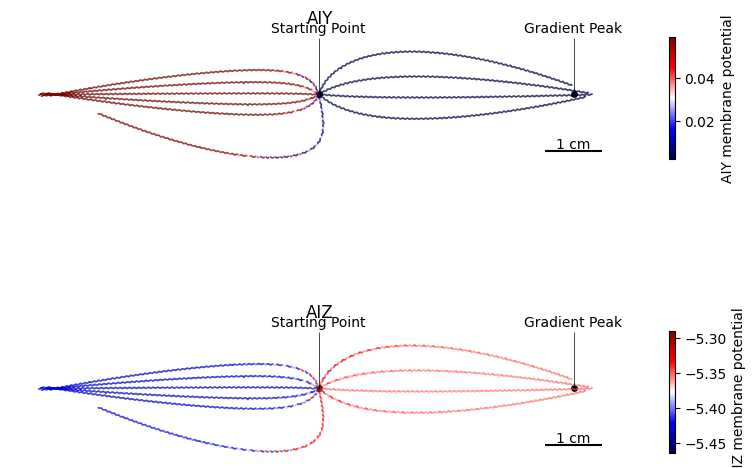

In [9]:
import load
import figure
import os

gene_number = 0

result = load.load_result_json(
    "../result/concentration_memory/Result_aiz_negative_{}.json".format(gene_number)
)

connectome_folder_path = "../figure/concentration_memory/two_gauss_concentration/Result_aiz_negative_{}/connectome".format(
    gene_number
)
os.makedirs(connectome_folder_path, exist_ok=True)
connectome_file_path_base = connectome_folder_path + "/connectome_"

N_T_in_file_path_base = "../output/concentration_memory/two_gauss_concentration/Result_aiz_negative_{}/n_vs_t_".format(
    gene_number
)
N_T_out_folder_path = "../figure/concentration_memory/two_gauss_concentration/Result_aiz_negative_{}/nomal_gradient_vs_turning_bias".format(
    gene_number
)
os.makedirs(N_T_out_folder_path, exist_ok=True)
N_T_out_file_path_base = N_T_out_folder_path + "/n_vs_t_"

membrane_potential_folder_path = "../figure/concentration_memory/two_gauss_concentration/Result_aiz_negative_{}/trajectory_membrane_potential".format(
    gene_number
)
os.makedirs(membrane_potential_folder_path, exist_ok=True)
membrane_potential_file_path_base = (
    membrane_potential_folder_path + "/trajectory_membrane_potential_"
)

newron_folder_path = "../figure/concentration_memory/two_gauss_concentration/Result_aiz_negative_{}/newron".format(
    gene_number
)
os.makedirs(newron_folder_path, exist_ok=True)
newron_file_path_base = newron_folder_path + "/newron_"

for i in range(11):
    gene = result[i]["gene"]
    # file_path = "{}{}".format(connectome_file_path_base, i)
    # figure.connectome(gene, file_path)
    in_file_path = "{}{}.txt".format(N_T_in_file_path_base, i)
    out_file_path = "{}{}".format(N_T_out_file_path_base, i)
    figure.Normal_gradient_vs_Turing_bias(in_file_path, out_file_path)
    file_path = "{}{}".format(membrane_potential_file_path_base, i)
    figure.trajectory_membrane_potential(gene, 2, 10, file_path)
    # file_path = "{}{}".format(newron_file_path_base, i)
    # figure.newron_output(gene, file_path)

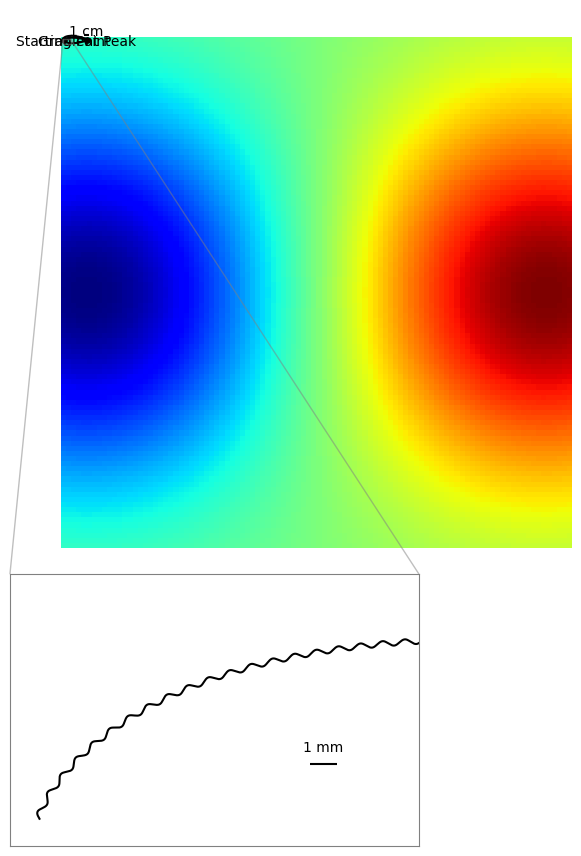

In [16]:
import numpy as np
import multiprocessing
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import oed
import load
import figure


def trajectory(gene, c_mode, lines_number, zoom_number, out_file_path):
    alpha, x_peak, y_peak, dt, T, f, v, time, tau, c_0, lambda_ = oed.constant(
        "setting"
    )
    fig, ax = plt.subplots(figsize=(10, 7))

    # マルチスレッドの使用プロセス数
    if lines_number < multiprocessing.cpu_count():
        process = lines_number
    else:
        process = multiprocessing.cpu_count()

    # マルチスレッドで処理する遺伝子と角度のリスト
    gene_angle_list = [
        [gene, angle, c_mode]
        for angle in np.arange(0, 2 * np.pi, 2 * np.pi / lines_number)
    ]

    # マルチスレッド処理
    with multiprocessing.Pool(process) as pool:
        results = pool.map(figure.calculate_trajectory, gene_angle_list)

    # トラジェクトリーの表示
    for idx, r in enumerate(results):
        ax.plot(r[0], r[1], color="black")

        if idx == zoom_number:
            r_ins = r
            ins_x_min = min(r[0])
            ins_y_min = min(r[1])

    # スタートとゴールの表示
    starting_point = [0, 0]
    peak = [x_peak, y_peak]

    ax.scatter(*starting_point, s=15, color="black")
    ax.scatter(*peak, s=15, color="black")

    y_max = 1
    ax.vlines(
        starting_point[0],
        starting_point[1],
        y_max,
        color="black",
        linestyle="-",
        linewidth=0.5,
    )
    ax.vlines(peak[0], peak[1], y_max, color="black", linestyle="-", linewidth=0.5)

    ax.text(
        starting_point[0], y_max + 0.1, "Starting Point", horizontalalignment="center"
    )
    ax.text(peak[0], y_max + 0.1, "Gradient Peak", horizontalalignment="center")

    # 軸メモリや枠を非表示にする
    ax.axis("off")
    ax.autoscale()
    ax.set_aspect("equal")

    # 基準の大きさを表示
    ax.text(4.5, -0.95, "1 cm", horizontalalignment="center")
    ax.hlines(-1, 4, 5, color="black", linestyle="-", linewidth=1.5)

    # インセットプロット
    axins = ax.inset_axes([-0.1, -0.7, 0.8, 0.8])
    axins.plot(r_ins[0], r_ins[1], color="black")

    axins.set_xlim(ins_x_min - 0.1, ins_x_min + 1.4)
    axins.set_ylim(ins_y_min - 0.1, ins_y_min + 0.9)

    axins.set_aspect("equal")
    axins.set_xticks([])
    axins.set_yticks([])
    for spine in axins.spines.values():
        spine.set_edgecolor("gray")

    axins.text(ins_x_min + 1.05, ins_y_min + 0.25, "1 mm", horizontalalignment="center")
    axins.hlines(
        ins_y_min + 0.2,
        ins_x_min + 1,
        ins_x_min + 1.1,
        color="black",
        linestyle="-",
        linewidth=1.5,
    )

    ax.indicate_inset_zoom(axins)

    # グラフの保存および表示
    plt.savefig(out_file_path, dpi=300)
    plt.show()

    return


result = load.load_result_json(
    "../result/concentration_memory/Result_aiz_negative_0.json"
)

gene = result[0]["gene"]
trajectory(gene, 2, 3, 1, "./test")